In [1]:
"""
#############################################################
SIMULATION CONFIGURATION FILE
#############################################################
This file contains all the header informations necessary to 
initialize a backtest. 

Please, read carefully all the explanations and report any 
bugs found in this file. 
"""

""" 
===============================================================================
MODULE IMPORTATION STEP
===============================================================================
This step is dedicated to specify the path at which the Q26 BackTester module 
is stored on your machine and to import the different important objects : 
    - SYMBOL            : This object correponds to the "broker" identity of 
                          the symbol to be backtested. 
    - PORTFOLIO         : This object corresponds to the portfolio to be 
                          simulated. 
    - PRICE/PRICE_TABLE : These objects refers to the datasets. 
    - SIMULATION        : This object corresponds to the simulation algorithm 
                          itself.
"""
# Usual modules importations 
import sys, os 
import numpy as np 
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 
import pprint
import copy 

# Relative or absolute path to Q26_BacktestSystem folder
# backTesterModulePath = "../"            
# sys.path.append(backTesterModulePath)

# Q26 BacktestSystem class importations 
from alphatrading.simulation.backtester.symbol     import SYMBOL
from alphatrading.simulation.backtester.portfolio  import PORTFOLIO 
from alphatrading.simulation.backtester.data       import PRICE 
from alphatrading.simulation.backtester.data       import PRICE_TABLE
from alphatrading.simulation.backtester.simulation import SIMULATION

In [2]:
""" 
===============================================================================
INITIALIZATION STEP : DATA PRICE PREPARATION
===============================================================================
"""

# We define the path to the dataset
path  = "../data/"
path += "exampleDataFile.csv"
# We create an object PRICE and give it a name 
price = PRICE("EUR.USD") 
# We associate the name of the columns in the datafile with 
# the properties of the PRICE object.
# In the specific case of the exampleDataFile.csv dataset, we do not have 
# any information of ask/bid price, so we consider by default that ask = bid 
# in the reading process. This will lead to a spread = 0.
price.setColumnsTitle(askOpen        ="open", 
                      askHigh        ="high",
                      askLow         ="low",
                      askClose       ="close", 
                      bidOpen        ="open",   
                      bidHigh        ="high",
                      bidLow         ="low",
                      bidClose       ="close",
                      dateFormat     ="%Y.%m.%d %H:%M", 
                      volume         ="vol",
                      splitDaysHours =True,  
                      days           ="date", 
                      hours          ="hour")
# We read the data
price.read(path)
# We define the timeframe associated to the loaded data 
price.setBaseTimeframe(timeframe = dt.timedelta(minutes = 1))
# We fill the missing data according to a data filling model 
price.fillMissingData()


# If necessary, we can shift our data 
price.shiftMarketTime(timeshift = 0)
# We can define the time zone in which data have been scraped (UTC+...)
price.dataTimeZone   = 0
# We can define the timezone in which the market is located (UTC+...)
price.marketTimeZone = 0
# We can define market opening/closing hours in the format "HH:MM"
# Note : If the market never close, the opening hour is "00:00"
#        while the closing hour is "24:00".
price.marketOpeningHour = "00:00"
price.marketClosingHour = "24:00"
# If the market has a mid day break or others breaks during the day 
# write it in the format : "HH:MM-HH:MM"
price.marketLunch    = None
marketBreakList      = list()
# Days of the week the market is open - 0 : Monday -> 6 : Sunday 
price.daysOfWeek = [0, 1, 2, 3, 4]
# Soon ... vacations 
# Function that define if the market is open/close 
price.setMarketState() 

# From the price object, it is possible to define another exact same object 
# thanks to the deepcopy function
price_H1 = price.createCopy()
# Here this dataset object is resampled to be used in the simulation. 
# The resampling process is exactly the same as you can see 
# on trading platforms. 
price_H1.resampleData("01:00", name = "EUR.USD")

# We generate our data table which will be involved in the simulation 
table = PRICE_TABLE([price, price_H1]) 
# In the case where we have more than 1 not resampled price, 
# the synchronize function will be necessary. 
table.synchronize()

In [3]:
""" 
===============================================================================
INITIALIZATION STEP : SYMBOL PROPERTIES IN THE BROKER FRAME
===============================================================================
Note : Fees are not yet implemented 
"""

symbol = SYMBOL(symbolName              = "EUR.USD",
                contractSize            = 100000, 
                marginCurrency          = "USD",    # Can be any existing currency (only USD is working for instance)
                profitCalculationMethod = "Forex",  # "CFD", "Forex", "Stock", "CFD-Index"
                marginRequestMethod     = "Forex",  # "CFD", "Forex", "Stock", "CFD-Index"
                marginPercentage        = 100, 
                execution               = "Market", 
                minimalVolume           = 0.01, 
                maximalVolume           = 100.0, 
                volumeStep              = 0.01, 
                precision               = 5,        # Price precision (3 means 1 point = 0.001)
                exchangeType            = "Point",  # "Point", "Percentage"
                exchangeLong            = 6.88, 
                exchangeShort           = 0.63)

In [4]:
""" 
===============================================================================
INITIALIZATION STEP : PORTFOLIO PROPERTIES
===============================================================================
"""

# We initialize our portfolio 
p = PORTFOLIO(initialDeposit                  = 100000,                # The initial client deposit 
              leverage                        = 30,                    # The leverage value (margin = initialDeposit*leverage)
              currency                        = "USD",                 # The currency 
              positions                       = "long & short",        # "long", "short" or "long & short"
              marginCallTreeshold             = 100,                   # If marginLevel < marginCallTreeshold : Warning (no more trading allowed)
              marginMinimum                   = 50,                    # If marginLevel < marginMinimum : Automatically close all losing positions 
              minimumBalance                  = 50000,                 # If balance < minimumBalance : No more trading allowed 
              maximumProfit                   = 100000,                # If balance - inialDeposit > maximumProfit : No more trading allowed 
              maximumDrawDown                 = 70,                    # If drawDown < maximumDrawDown : No more trading allowed 
              maximumConsecutiveLoss          = 50000,                 # If valueLossSerie > maximumConsecutiveLoss : No more trading allowed 
              maximumConsecutiveGain          = 50000,                 # If valueGainSerie > maximumConsecutiveGain : No more trading allowed 
              maximumNumberOfConsecutiveGains = 30)

# We add the symbol identity we created inside the portfolio object 
p.addSymbol(symbol)

In [6]:
""" 
===============================================================================
SIMULATION STEP
===============================================================================
"""
# We initialize the simulation object 
sim = SIMULATION([p], table)

sim.subLoopModel = "close only"
sim.maxHstDataSize = 2000
sim.startIndex = 2000
# sim.stopIndex  = 2010
sim.logEvery = 100


# Relative or absolute pathe to the strategy file
# and strategy class importation  
sim.strategyPath = ["./"]
sim.strategyFile = ["strategyExample"]
sim.importStrategy()

# Check of the simulation parameters (not yet working)
sim.parametersCheck()

# We ignore the simulation warnings 
sim.hideWarnings = True 

tables = [
    {"name"     : "simulation_variables", 
     "structure": {
         "date"                                       : "str", 
         "available_margin"                           : "float",
         "balance"                                    : "float", 
         "number_closed_positions"                    : "int",
         "number_currently_open_positions"            : "int",
         "number_pending_orders"                      : "int",
         "current_drawdown"                           : "float", 
         "current_maximum_number_of_consecutive_gains": "int", 
         "current_value_gain_serie"                   : "float", 
         "current_value_loss_serie"                   : "float", 
         "equity_balance"                             : "float", 
         "number_executed_orders"                     : "int", 
         "margin_level"                               : "float", 
         "used_margin"                                : "float"
     }}
]


sim.set_database(client_id=0, 
                 name="sma_crossover_strategy_logfile", 
                 path="./", 
                 model="sqlite3", 
                 log = False, 
                 tables = tables)

Everything is fine, the simulation can be launched !
This functionnality is not working for instance and need to be coded


In [7]:
# Run of the simulation 
sim.run(mode = "linear")

SIMULATION :  0 / 1
Simulation :  0  - i =  4.62973679946295  %
Simulation :  0  - i =  4.861223639436098  %
Simulation :  0  - i =  5.092710479409246  %
Simulation :  0  - i =  5.324197319382393  %
Simulation :  0  - i =  5.555684159355541  %
Simulation :  0  - i =  5.787170999328688  %
Simulation :  0  - i =  6.018657839301836  %
Simulation :  0  - i =  6.250144679274983  %
Simulation :  0  - i =  6.481631519248131  %
Simulation :  0  - i =  6.713118359221277  %
Simulation :  0  - i =  6.9446051991944255  %
Simulation :  0  - i =  7.176092039167574  %
Simulation :  0  - i =  7.407578879140721  %
Simulation :  0  - i =  7.639065719113869  %
Simulation :  0  - i =  7.870552559087016  %
Simulation :  0  - i =  8.102039399060164  %
Simulation :  0  - i =  8.333526239033311  %
Simulation :  0  - i =  8.565013079006459  %
Simulation :  0  - i =  8.796499918979606  %
Simulation :  0  - i =  9.027986758952753  %
Simulation :  0  - i =  9.2594735989259  %
Simulation :  0  - i =  9.49096043889

{'Average trade duration': '0:34:22.751505',
 'Cumulated gains': 1199.9999999999982,
 'Cumulated losses': -1357.7000000000276,
 'End date': '2020-01-31 16:58:00',
 'Initial Deposit': 100000,
 'Loosers average loss': -1.9340455840456232,
 'Loosers average loss percentage': -0.0019340455840456234,
 'Loosers ratio': 0.5308284787113476,
 'Max trade duration': '2 days, 7:14:00',
 'Maximum drawdown': 0.003060692238050209,
 'Min trade duration': '0:01:00',
 'Number of loosers': 702,
 'Number of loosers long': 356,
 'Number of loosers short': 346,
 'Number of transactions': 1163,
 'Number of winners': 461,
 'Number of winners long': 228,
 'Number of winners short': 233,
 'Number trades still open': 1,
 'P&L': -157.70000000003012,
 'P&L in percentage': -0.15770000000003012,
 'Profit factor': -0.88384768358251,
 'Start date': '2020-01-03 02:20:00',
 'Symbols': ['EUR.USD'],
 'Winners average gain': 2.6030368763557443,
 'Winners average gain percentage': 0.0026030368763557445,
 'Winners ratio': 0.

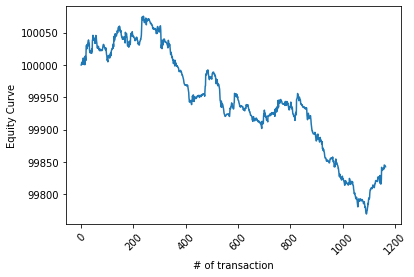

In [9]:
import pprint as pp
""" 
===============================================================================
RESULTS STEP
===============================================================================
"""
# We print some basic simulation results 
results = sim.get_basic_results(client_id=0)
pp.pprint(results)
# We write the results in a csv file 
sim.writeClosedPositionsFile(index = 0)
# We plot the equity curve 
fig, ax = sim.showEquityCurve(index = [0])